# ABC to ABC

**Author**: Guillermo Romero Moreno <Guillermo.RomeroMoreno@ed.ac.uk> <br/>
**Date**: April 2024 <br/>
**License**: CC-BY-4.0<br/>

This tutorial will cover the basics of the ABC method and show how to implement and fit a model.

First, let's load all required packages.

In [1]:
%load_ext autoreload
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
    
import os, sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

print('python', sys.version)
print('numpy', np.__version__)
print('networkx', nx.__version__)
print('pandas', pd.__version__)

python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
numpy 1.22.3
scipy 1.8.0
networkx 2.8
pandas 1.4.2


Now let's load the packages from the repository. To be able to detect them, you have to make sure that they can be detected, for which we use `sys.path.insert` below. Note that the code below assumes that this notebook is located in the folder `notebooks/`, so detecting the root folder is by adding the folder just above (`'../'`) to the system path. IF THE NOTEBOOK IS ANYWHERE ELSE WITHIN THE REPOSITORY, YOU'LL NEED TO CHANGE `'../'` ACCORDING TO THE RELATIVE PATH TO THE ROOT FOLDER.

In [2]:
thisdir = os.path.abspath('')
libdir = os.path.join(thisdir, '../')

if libdir not in sys.path:
    sys.path.insert(0, libdir)

from ABC.utils import MLTC_count, identify_LTC, compute_RR
from ABC.data import load_dataset, stratify_dataset, beautify_index, beautify_name
from ABC.results import compute_communities, get_top_associations, plot_ABC_vs_RR, plot_tops, build_network, plot_network
from ABC.model import ABCModel, probability_of_larger

# Load the data

To show the basic implementation of the ABC model, we will use a publicly available dataset in this tutorial --- the [CDC *'Diabetes Health Indicator Dataset'*](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset), with 253,680 patients and 21 variables

The dataset can be easily downloaded via the [`ucimlrepo`](https://github.com/uci-ml-repo/ucimlrepo) package.

In [3]:
from ucimlrepo import fetch_ucirepo 
  
dataset = fetch_ucirepo(name='CDC Diabetes Health Indicators') 
print(dataset.metadata['abstract'])
print("Number of patients:", dataset.metadata['num_instances'], ", Number of variables", dataset.metadata['num_features'])

data = pd.concat([dataset.data.features, dataset.data.targets ], axis=1)  # load the data
var_info = dataset.variables  # load variable metadata
var_info

The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. 
Number of patients: 253680 , Number of variables 21


,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in you...,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not includ...,None,no


For applying the ABC method, we'll only use binary variables, i.e.

In [14]:
bin_vars = var_info[var_info["type"] == "Binary"]["name"].to_list()
print((N := len(bin_vars)), "binary variables will be used, with", len((triu := np.triu_indices(n=N, k=1))[0]), "potential pairwise associations.")
var_info[var_info["name"].isin(bin_vars)]

15 binary variables will be used, with 105 potential pairwise associations.


,name,role,type,demographic,description,units,missing_values
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in you...,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not includ...,None,no
10,Fruits,Feature,Binary,None,Consume Fruit 1 or more times per day 0 = no 1...,None,no
11,Veggies,Feature,Binary,None,Consume Vegetables 1 or more times per day 0 =...,None,no


# Fit the model

Fitting the model is very simple. You just need to load the model class `ABCModel` and fit it to the data with the method `load_fit`.

The `ABCModel` class loads the *Stan* model specified by the `model_name` argument, located in the `models/` folder. As default, the `MLTC_atomic_hyp_mult.stan` file is loaded, which is the one specifying our model, but you can write and test variations on the model.

In [5]:
model = ABCModel(model_name="MLTC_atomic_hyp_mult", verbose=True)

data {
  int<lower=1> n;  // Number of morbidities
  array[n,n] int<lower=0> X;  // Co-occurrence observation matrix
  int<lower=1> M;  // number of patients
  array[n] int<lower=0, upper=M> P;  // Prevalence of conditions
  
  // Upper bounds of parameters
  array[n,n] real<lower=0> upper_r;
  array[n] real<lower=0> upper_sigma;
}
parameters {
  array[n] real<lower=0, upper=upper_sigma> sigma;  // prob of a morbidity to emerge independently
  array[n,n] real<lower=-1, upper=upper_r> r;  // positive co-morbidity interactions
  
  // Lognormal prior for associations
  real mu_lognormal_prior;
  real<lower=0> std_lognormal_prior;
  
  // Beta prior for sigma values
  real<lower=1> alpha_beta_prior;
  real<lower=1> beta_beta_prior;
}
model {
  // Priors
  alpha_beta_prior - 1 ~ exponential(0.01);
  beta_beta_prior - 1 ~ exponential(0.01);
  for (i in 1:n) {
    sigma[i] ~ beta(alpha_beta_prior, beta_beta_prior);
  }
  
  mu_lognormal_prior ~ normal(0, 1);
  std_lognormal_prior ~ exponenti

The `load_fit` needs three arguments: 1) the dataframe object with your data, 2) the list of (binary) columns to use, and the name of the saved model after fitting, which will be loaded if already fitted previously or will fit a new one and save it if not previous model was found.

If a new model is to be fit, the `load_fit` method will also need arguments related to the MCMC sampling algorithm ([Hamiltonian Monte Carlo](https://mc-stan.org/docs/2_29/reference-manual/hmc.html)), such as
- `num_chains`: these are the number of different HMC processes that are run independently, each starting from different initial parameters. A high number ensures that all modes of the parameter space are explored, in case it is multimodal, and results are not dependent on the stochasticity of the initial parameters.
- `num_warmup`: the number of samples to draw to allow the MCMC to stabilise, which will be discarded. These are used for adapting the step size and letting the system to converge to the steady state, and the sampling of the posterior only occurs after the warm-up iterations.
- `num_samples`: the number of samples to draw for the posterior distribution  (once in the steady state), and which are used in the results.
- other *optional* arguments, such as the `random_seed`. (For more information on additional arguments, see the [*cmdstanpy* documentation](https://cmdstanpy.readthedocs.io/en/stable-0.9.65/sample.html#nuts-hmc-sampler-configuration).)

In [10]:
model.load_fit(data, column_names=bin_vars, fname="fit_model",
              num_chains=5, num_warmup=500, num_samples=2000)

Model '/disk/scratch/gromero/output/fit_model' not found, fitting new model...
Shape of co-occurrence matrix: (15, 15)


18:31:26 - cmdstanpy - INFO - CmdStan start processing


CmdStanModel: name=MLTC_atomic_hyp_mult
	 stan_file=/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult.stan
	 exe_file=/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult
	 compiler_options=stanc_options={}, cpp_options={} {'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '0', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}
Sampling with params: {num_chains: 5, num_samples: 2000, num_warmup: 500}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

18:31:41 - cmdstanpy - INFO - CmdStan done processing.
18:31:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lp


Elapsed time: 00 hours, 00 minutes, 14 seconds.
Processing csv files: /tmp/tmpv9lbj_v1/MLTC_atomic_hyp_multzsbqttvv/MLTC_atomic_hyp_mult-20240408183126_1.csv, /tmp/tmpv9lbj_v1/MLTC_atomic_hyp_multzsbqttvv/MLTC_atomic_hyp_mult-20240408183126_2.csv, /tmp/tmpv9lbj_v1/MLTC_atomic_hyp_multzsbqttvv/MLTC_atomic_hyp_mult-20240408183126_3.csv, /tmp/tmpv9lbj_v1/MLTC_atomic_hyp_multzsbqttvv/MLTC_atomic_hyp_mult-20240408183126_4.csv, /tmp/tmpv9lbj_v1/MLTC_atomic_hyp_multzsbqttvv/MLTC_atomic_hyp_mult-20240408183126_5.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.

                       Mean          MCSE      StdDev            5%  \
lp__          -2.349720e+07  5.217730

False

Some warnings may appear. If unsure about their meaning, you can see [here](https://mc-stan.org/misc/warnings.html).

As you can see from the diagnotics, the *"Split R-hat values satisfactory all parameters"*, which means the the `num_warmup` parameter was sufficiently high. If the *Split R-hat value* was reported as unsatisfactory for some parameter, consider re-running the model with a higher `num_warmup` value.

# Analyse results

You can retrieve the distributions of associations with the method `get_associations`:

In [44]:
ABCs = model.get_associations()
ABCs.shape

(15, 15, 10000)

or retrieve a specific association pair:

(10000,)

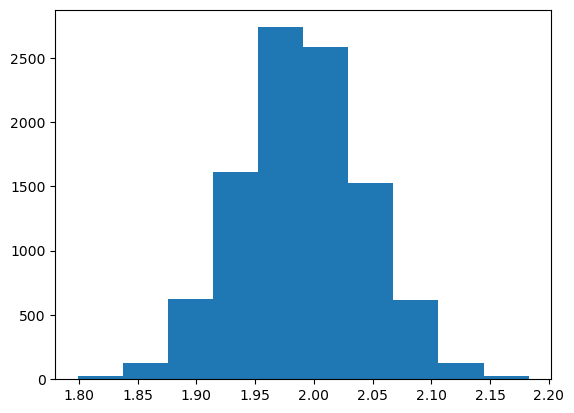

In [52]:
ABC_DS = model.get_associations(LTC1="Diabetes_binary", LTC2="Stroke")
plt.hist(ABC_DS);
ABC_DS.shape

Alternatively, you can obtain a dataframe summarising the main statistics of the ABC results with the method `get_results_dataframe`. This method also computes RR associations and includes them in the dataframe.

The method requires two arguments:
- `significance_pvalue`: which is the p-value used to compute significance for both ABC and RR associations (using Fisher's exact test)
- `credibla_inteval_pvalue`: which is the value to delimitate the span of the credible (confidence) intervals

In [54]:
results_df = model.get_results_dataframe(significance_pvalue=0.05, credible_inteval_pvalue=0.05)
print(f"Significant associatons:   Fisher (RR): {results_df['fisher_sig'].sum():.0f} ({100*results_df['fisher_sig'].sum()/len(triu[0]):.1f}%), "
          f"ABC: {results_df['a_sig'].sum():3.0f} ({100*results_df['a_sig'].sum()/len(triu[0]):.1f}%)")
results_df

Significant associatons:   Fisher (RR): 104 (99.0%), ABC:  96 (91.4%)


,i,j,namei,namej,names,Xi,Xj,Xij,Pi,Pj,...,ABC_error_up,a_f,a CI (99%),a_f_sig,a_f_sig_CI,RR_error_down,RR_error_up,RR_f,RR CI (99%),RR_f_sig_CI
names,,,,,,,,,,,,,,,,,,,,,
Diabetes_binary-HighBP,0,1,Diabetes_binary,HighBP,Diabetes_binary-HighBP,35346,108829,26604,0.139333,0.429001,...,2.621100e-02,2.09,2.07 - 2.12,2.09,2.09 (2.07 - 2.12),0.000116,0.000116,1.75,1.75 - 1.75,1.75 (1.75 - 1.75)
Diabetes_binary-HighChol,0,2,Diabetes_binary,HighChol,Diabetes_binary-HighChol,35346,107591,23686,0.139333,0.424121,...,2.142757e-02,1.88,1.85 - 1.9,1.88,1.88 (1.85 - 1.9),0.000119,0.000119,1.58,1.58 - 1.58,1.58 (1.58 - 1.58)
Diabetes_binary-CholCheck,0,3,Diabetes_binary,CholCheck,Diabetes_binary-CholCheck,35346,244210,35105,0.139333,0.962670,...,1.561912e-02,1.17,1.16 - 1.19,1.17,1.17 (1.16 - 1.19),0.000050,0.000050,1.03,1.03 - 1.03,1.03 (1.03 - 1.03)
Diabetes_binary-Smoker,0,4,Diabetes_binary,Smoker,Diabetes_binary-Smoker,35346,112423,18317,0.139333,0.443169,...,2.486105e-02,1.34,1.33 - 1.37,1.34,1.34 (1.33 - 1.37),0.000116,0.000116,1.17,1.17 - 1.17,1.17 (1.17 - 1.17)
Diabetes_binary-Stroke,0,5,Diabetes_binary,Stroke,Diabetes_binary-Stroke,35346,10292,3268,0.139333,0.040571,...,1.081652e-01,2.99,2.89 - 3.1,2.99,2.99 (2.89 - 3.1),0.001349,0.001350,2.28,2.28 - 2.28,2.28 (2.28 - 2.28)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AnyHealthcare-DiffWalk,11,13,AnyHealthcare,DiffWalk,AnyHealthcare-DiffWalk,241263,42675,40731,0.951053,0.168224,...,-1.989150e-07,1.0,0.998 - 1.0,1.0,1.0 (0.998 - 1.0),0.000041,0.000041,1.0,1.0 - 1.0,1.0 (1.0 - 1.0)
AnyHealthcare-Sex,11,14,AnyHealthcare,Sex,AnyHealthcare-Sex,241263,111706,105711,0.951053,0.440342,...,1.235652e-03,0.999,0.991 - 1.0,0.999,0.999 (0.991 - 1.0),0.000011,0.000011,0.995,0.995 - 0.995,0.995 (0.995 - 0.995)
NoDocbcCost-DiffWalk,12,13,NoDocbcCost,DiffWalk,NoDocbcCost-DiffWalk,21354,42675,6713,0.084177,0.168224,...,5.108375e-02,1.97,1.92 - 2.02,1.97,1.97 (1.92 - 2.02),0.000531,0.000531,1.87,1.87 - 1.87,1.87 (1.87 - 1.87)


The top found associations are

In [25]:
get_top_associations(results_df)[0]

,a_f_sig_CI,RR_f_sig_CI
Stroke - Heart diseaseor attack,5.54 (5.39 - 5.74),4.06 (4.06 - 4.06)
Stroke - Diff walk,3.6 (3.5 - 3.71),2.91 (2.91 - 2.91)
Diabetes - Heart diseaseor attack,3.09 (3.04 - 3.17),2.37 (2.37 - 2.37)
Heart diseaseor attack - Diff walk,3.06 (3.0 - 3.12),2.47 (2.47 - 2.47)
Diabetes - Stroke,2.99 (2.89 - 3.1),2.28 (2.28 - 2.28)
Diabetes - Diff walk,2.63 (2.58 - 2.67),2.21 (2.21 - 2.21)
High bp - Heart diseaseor attack,2.16 (2.13 - 2.2),1.75 (1.75 - 1.75)
High bp - Stroke,2.12 (2.07 - 2.17),1.73 (1.73 - 1.73)
Diabetes - High bp,2.09 (2.07 - 2.12),1.75 (1.75 - 1.75)
High chol - Heart diseaseor attack,2.03 (2.0 - 2.07),1.65 (1.65 - 1.65)


You can also visualise them on a heatmap (or a bubble plot) with the method `plot_heatmap`.

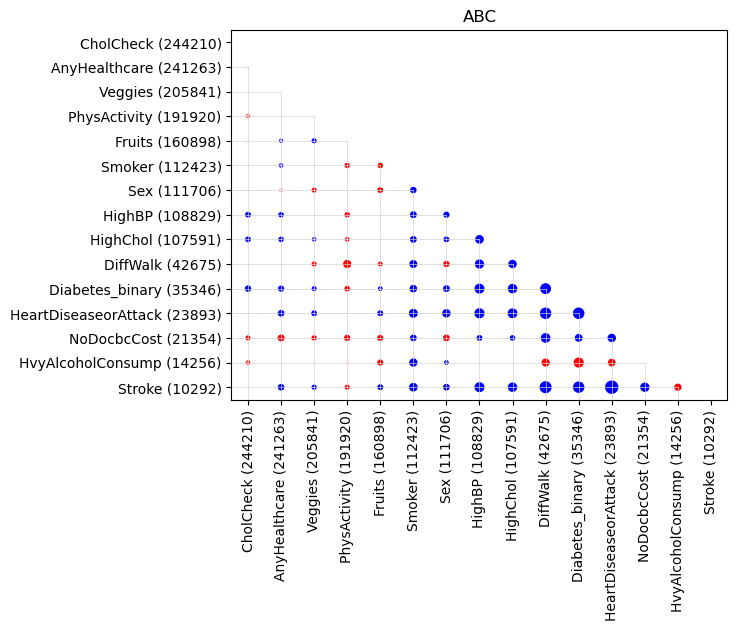

In [55]:
model.plot_heatmap("ABC", bubbles=True);

Further, a *networkx* `Graph` object corresponding to the network of associations can be obtained with the functions `build_network`.

In [65]:
network, network_df = build_network(results_df, "ABC", morbidity_names=bin_vars)
type(network)

Original size: 96 edges, 15 nodes, 

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/notebooks/../lib/results.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_df.loc[:, "i_abs"] = network_df.loc[:, "i"]
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/notebooks/../lib/results.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_df.loc[:, "j_abs"] = network_df.loc[:, "j"]


networkx.classes.graph.Graph

 You can plot this network using the package *bokeh* and the function `plot_network`.

In [66]:
from bokeh.io import output_notebook, show, save
output_notebook()

Loading BokehJS ...

In [75]:
G_ABC, ax1, comm_ABC = plot_network(network, network_df, "ABC", communities=True, layout=nx.circular_layout,
                                    figsize=(600, 550), interactive=True, prev_size=True, community_weight=True, span=13)
show(ax1)

Modularity: 0.0642677560913505 coverage-performance (0.6770833333333334, 0.6666666666666666)


# About *Stan* and the model specification

*[Stan](https://mc-stan.org/)* is a state-of-the-art platform for statistical modeling and high-performance statistical computation. While *Stan* can be operated using interfaces from common programming languages (*python*, *R*, *MATLAB*, etc), it uses its own language for model specification.

Some general references to *Stan*:

- [Stan User's Guide](https://mc-stan.org/docs/2_29/stan-users-guide/index.html)
- [Stan Reference Manual](https://mc-stan.org/docs/2_29/reference-manual/index.html)
- [Stan Functions Reference](https://mc-stan.org/docs/2_29/functions-reference/index.html).

You can find the code that we used to define our model in the file `models/MLTC_atomic_hyp_mult.stan`, or alternatively, in the `model_code` attribute of the model object:

In [77]:
print(model.model_code)

data {
  int<lower=1> n;  // Number of morbidities
  array[n,n] int<lower=0> X;  // Co-occurrence observation matrix
  int<lower=1> M;  // number of patients
  array[n] int<lower=0, upper=M> P;  // Prevalence of conditions
  
  // Upper bounds of parameters
  array[n,n] real<lower=0> upper_r;
  array[n] real<lower=0> upper_sigma;
}
parameters {
  array[n] real<lower=0, upper=upper_sigma> sigma;  // prob of a morbidity to emerge independently
  array[n,n] real<lower=-1, upper=upper_r> r;  // positive co-morbidity interactions
  
  // Lognormal prior for associations
  real mu_lognormal_prior;
  real<lower=0> std_lognormal_prior;
  
  // Beta prior for sigma values
  real<lower=1> alpha_beta_prior;
  real<lower=1> beta_beta_prior;
}
model {
  // Priors
  alpha_beta_prior - 1 ~ exponential(0.01);
  beta_beta_prior - 1 ~ exponential(0.01);
  for (i in 1:n) {
    sigma[i] ~ beta(alpha_beta_prior, beta_beta_prior);
  }
  
  mu_lognormal_prior ~ normal(0, 1);
  std_lognormal_prior ~ exponenti

Note that this code has four different blocks ('data', 'parameters', 'model', and 'generated_quantities'), which we'll cover one by one below.

## The 'data' block

The 'data' block defines the data variables that are going to be taken as input when fitting the model:

```
data {
  int<lower=1> n;  // Number of morbidities
  array[n,n] int<lower=0> X;  // Co-occurrence observation matrix
  int<lower=1> M;  // number of patients
  array[n] int<lower=0, upper=M> P;  // Prevalence of conditions
  
  // Upper bounds of parameters
  array[n,n] real<lower=0> upper_r;
  array[n] real<lower=0> upper_sigma;
}
```

In our case, we have
- `n`, defining the number of morbidities (and size of matrices and vectors). It is an integer with a minimum value of 1.
- `X`, the square matrix with co-occurrences of LTCs. It's symmetric, of size $n$ x $n$, and with non-negative integer values.
- `M`, the number of patients in the sample, so an integer with minimum value of 1.
- `P`, the number of cases per condition, hence an vector of size $n$ with integer values between $0$ and $M$
- `upper_r` and `upper_sigma`, positive real numbers that define the upper bounds of ABC associations (`upper_r`) and the values of common factors $f_i$ (`upper_sigma`). These constraints ensure the model does not diverge.

## The 'parameters' block

The 'parameters' block defines the model variables that are going to be inferred from the data.
```
parameters {
  array[n] real<lower=0, upper=upper_sigma> sigma;  // prob of a morbidity to emerge independently
  array[n,n] real<lower=-1, upper=upper_r> r;  // positive co-morbidity interactions
  
  // Lognormal prior for associations
  real<lower=0> std_lognormal_prior;
  
  // Beta prior for sigma values
  real<lower=1> alpha_beta_prior;
  real<lower=1> beta_beta_prior;
}
```

In our case,
- `sigma` is vector off size `n` containing the independent risk factors of each LTC ($f_i$), which is bounded between $0$ and `upper_sigma` (which has to be lower or equal to one)
- `r` is the $n$ x $n$ matrix containing the $ABC$ values
- `mu_lognormal_prior` and `std_lognormal_prior` are the parameters of the prior distributions to the $ABC$ (`r`) values.
- `alpha_beta_prior` and `beta_beta_prior` are the parameters of the prior distributions to the $f_i$ (`sigma`) values.

## The 'model' block

The 'model' block defines the generative model containing the model parameters defined above and their relation to the data.
```
model {
  // sigma priors
  alpha_beta_prior - 1 ~ exponential(0.01);
  beta_beta_prior - 1 ~ exponential(0.01);
  for (i in 1:n) {
    sigma[i] ~ beta(alpha_beta_prior, beta_beta_prior);
  }
  
  std_lognormal_prior ~ exponential(1); // ABC prior parameter
  for (i in 1:n) {
    for (j in i + 1:n) {
      r[i,j] + 1 ~ lognormal(0, std_lognormal_prior);
      
      // Likelihood
      real mu_11 = sigma[i] * sigma[j] * (1 + r[i,j] * (1 - sigma[i] * sigma[j]));
      real mu_10 = sigma[i] * (1 - sigma[j]) * (1 - sigma[i] * sigma[j] * r[i,j]);
      real mu_01 = sigma[j] * (1 - sigma[i]) * (1 - sigma[j] * sigma[i] * r[i,j]);
      real mu_00 = (1 - sigma[i]) * (1 - sigma[j]) * (1 - sigma[i] * sigma[j] * r[i,j]);
      
      array[4] int y = { X[i,j], P[i] - X[i,j], P[j] - X[i,j], M - P[i] - P[j] + X[i,j] };
      vector[4] theta = [mu_11, mu_10, mu_01, mu_00]';
      y ~ multinomial(theta);
    }
  }
}
```

The 'model' block starts by defining the priors for `sigma` ($f_i$) as a [beta distributino](https://www.wolframalpha.com/input?i=beta+distribution+%282%2C10%29) whose parameters $\alpha$ and $\beta$ come from a hyper-prior [exponential distribution](https://www.wolframalpha.com/input?i=exponential+distribution) with parameter $\lambda=0.01$.
Then, the prior for association values (`r`) is defined as a log-normal distribution with parameters $\mu=0$ and a standard deviation coming from a exponential hyper-prior with $\lambda=1$.
For more information about possibilities of prior choices, check [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) and [here](https://mc-stan.org/docs/2_29/stan-users-guide/regression-priors.html).

Last, the probabilities of co-occurrence between each pair of conditions is given by a multinomial with probabilities defined by

\begin{equation}
    \left\{\begin{array}{cc}%c}
         \mathbb{P}\left(LTC_i = 1, LTC_j = 1 | f_i, f_j, f_{ij}\right) = & f_{ij} + f_i f_j - f_{ij} f_i f_j \\ 
         \mathbb{P}\left(LTC_i = 1, LTC_j = 0 | f_i, f_j, f_{ij}\right) = & f_i ( 1 - f_j ) ( 1 - f_{ij} ) \\
         \mathbb{P}\left(LTC_i = 0, LTC_j = 1 | f_i, f_j, f_{ij}\right) = & f_j ( 1 - f_i ) ( 1 - f_{ij} ) \\
         \mathbb{P}\left(LTC_i = 0, LTC_j = 0 | f_i, f_j, f_{ij}\right) = & ( 1 - f_i ) ( 1 - f_j ) ( 1 - f_{ij} )
    \end{array}\right. \; ,
    \end{equation}
    
For more detailed information about the model definition, check the [supplementary material](https://ars.els-cdn.com/content/image/1-s2.0-S2352396424001166-mmc1.pdf) of the paper.

## The 'generated_quantities' block

The 'generated_quantities' block defines additional output variables to be produced by the model, such as additional data generated by the model to be used for a *prior-* or *posterior-predictive check*.
```
generated quantities {
  // Prior predictive check
  real<lower=1> alpha_prior = 1 + exponential_rng(0.01);
  real<lower=1> beta_prior = 1 + exponential_rng(0.01);
  array[n] real sigma_priors;
  array[n] real sigma_prior_post;
  for (i in 1:n) {
    sigma_priors[i] = beta_rng(alpha_prior, beta_prior);
    sigma_prior_post[i] = beta_rng(alpha_beta_prior, beta_beta_prior);
  }
  
  real<lower=0> std_prior = exponential_rng(1);
  array[n,n] real r_priors;
  
  array[n,n] int X_post;
  array[n,n] int P_post;
  for (i in 1:n){
    for (j in i + 1:n){
      r_priors[i,j] = - 1 + lognormal_rng(0, std_prior);

      real mu_11 = sigma[i] * sigma[j] * (1 + r[i,j] * (1 - sigma[i] * sigma[j]));
      real mu_10 = sigma[i] * (1 - sigma[j]) * (1 - sigma[i] * sigma[j] * r[i,j]);
      real mu_01 = sigma[j] * (1 - sigma[i]) * (1 - sigma[j] * sigma[i] * r[i,j]);
      real mu_00 = (1 - sigma[i]) * (1 - sigma[j]) * (1 - sigma[i] * sigma[j] * r[i,j]);
      vector[4] theta = [mu_11, mu_10, mu_01, mu_00]';
      
      array[4] int y = multinomial_rng(theta, M);
      X_post[i,j] = y[1];
      P_post[i,j] = y[2] + y[1];
      P_post[j,i] = y[3] + y[1];
    }
  }
}
```

In our case, the variables `sigma_priors` can be used to draw samples from the beta prior distributions for $f_i$ (`sigma`) with parameters $\alpha$ and $\beta$ drawn from the exponential hyper-priors, while `sigma_prior_post` draws samples from the beta prior distributions for $f_i$ using the prior parameters $\alpha^*$ and $\beta^*$ found by the fitted model.

Analogously, `r_priors` can be used to draw samples from the log-normal prior distributions for $ABC_{ij}$ (`r`) with standard deviation parameter drawn from the exponential hyper-prior.

Last, `X_post` and `P_post` generate new data for co-occurrence matrices and numbers of cases per condition from the fitted generative model.